# Error Backpropagation / Convolutional Neural Networks

The purpose of this notebook is to practice implementing the error backpropagation algorithm and the convolutional layers of CNN models.

We will implement the backpropagation algorithm and a 1-D convolution in numpy, and use TensorFlow to train a CNN model.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## 1. Error Backpropagation

In this section we will practice implementing the backpropagation algorithm to compute gradients for an MLP with a single hidden layer, and train the model by applying the computed gradients with a network optimiser.

For this tutorial we will use the [QSAR fish toxicity dataset](https://archive.ics.uci.edu/ml/datasets/QSAR+fish+toxicity) from the UCI machine learning repository.

We will start by loading this dataset.

In [2]:
# Load the data from CSV

data = pd.read_csv('./data/qsar_fish_toxicity.csv', sep=';', header=None)
x = data.iloc[:, :6]  ## <-- inputs
y = data.iloc[:, 6:]  ## <-- targets

In [3]:
# Create training and validation splits

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [4]:
# Standardise the inputs

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [5]:
# Load the data into Dataset objects

train_data = tf.data.Dataset.from_tensor_slices((x_train.astype(np.float32), y_train.astype(np.float32)))
train_data = train_data.shuffle(1202)
train_data = train_data.batch(128)

test_data = tf.data.Dataset.from_tensor_slices((x_test.astype(np.float32), y_test.astype(np.float32)))
test_data = test_data.batch(128)

train_data.element_spec

(TensorSpec(shape=(None, 6), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))

We will use an MLP model with a single hidden layer with 64 neurons, and a tanh activation function. The output layer has 1 neuron and no activation function.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(64, activation='tanh', input_shape=(6,)),
    Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                448       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(loss='mse')
model.evaluate(test_data)

2/2 [==============================] - 0s 2ms/step - loss: 19.0883


18.911754608154297

This MLP model has two kernel variables and two bias variables.

In [8]:
W0 = model.layers[0].kernel
b0 = model.layers[0].bias

W1 = model.layers[1].kernel
b1 = model.layers[1].bias

In this tutorial we will implement the forward and backward pass of backpropagation manually.

The following function implements the dense layer transformation to obtain the pre-activation values.

In [9]:
def dense(h, W, b):
    
    # h: K x h_in array of inputs
    # W: h_in x h_out array for kernel matrix parameters
    # b: Length h_out 1-D array for bias parameters
    # returns: K x h_out output array 
    
    return b + h @ W

Recall that the backpropagation algorithm can be summarised as follows:

>1. Define the **error** $\delta^{(k)}_p := \frac{\partial \mathcal{L}_i}{\partial a^{(k)}_p}$ for layer $k$, where we denote $\mathcal{L}_i$ as the loss for example $i$, and $a^{(k)}_p$ is the $p$-th pre-activation in layer $k$
>2. Propagate the signal forwards by passing an input vector $x_i$ through the network and computing all pre-activations and post-activations using $\mathbf{a}^{(k)} = (\boldsymbol{h}^{(k-1)})^T\boldsymbol{W}^{(k-1)} + \boldsymbol{b}^{(k-1)}$
> 3. Evaluate $\boldsymbol{\delta}^{(L+1)} = \frac{\partial \mathcal{L}_i}{\partial \boldsymbol{a}^{(L+1)}}$ for the output neurons
> 4. Backpropagate the errors to compute $\mathbf{\delta}^{(k)}$ for each hidden unit using $\boldsymbol{\delta}^{(k)} = \boldsymbol{\sigma}'(\boldsymbol{a}^{(k)})  \boldsymbol{W}^{(k)} \boldsymbol{\delta}^{(k+1)}$
> 5. Obtain the derivatives of $\mathcal{L}_i$ with respect to the weights and biases using $\frac{\partial \mathcal{L}_i}{\partial w^{(k)}_{pq}} = \delta^{(k+1)}_p h^{(k)}_q,\quad 
\frac{\partial \mathcal{L}_i}{\partial b^{(k)}_{p}} = \delta^{(k+1)}_p$

In the above, $\boldsymbol{\sigma}'(\boldsymbol{a}^{(k)})$ is a diagonal matrix with diagonal elements $\sigma'(a^{(k)}_p)$, $p=1,\ldots,n_k$, where $n_k$ is the number of neurons in hidden layer $k$.

In our case, we have an MLP with one hidden layer ($L=1$). The loss $\mathcal{L}_i$ for data example $(x_i, y_i)$ will be the mean squared error

$$
\mathcal{L}_i = \frac{1}{2}(y_i - f(x_i))^2,
$$

where $f:\mathbb{R}^6\mapsto\mathbb{R}$ is the MLP network.

We will start by computing the output error $\boldsymbol{\delta}^{(2)} = \frac{\partial \mathcal{L}_i}{\partial \boldsymbol{a}^{(2)}}$.

In [10]:
## EDIT THIS FUNCTION
def output_error(y_batch, a2):
    
    # y_batch: K x 1 array of data outputs
    # a2: K x 1 array of output pre-activations
    # returns: K x 1 array of output errors 
    
    return a2 - y_batch

We will also need to compute the diagonal matrix $\boldsymbol{\sigma}'(\boldsymbol{a}^{(1)})$:

In [11]:
## EDIT THIS FUNCTION
def activation_derivative(a1):
    
    # a1: K x 64 array of hidden layer pre-activations
    # returns: K x 64 array of diagonal elements  
    
    return 1 - np.square(np.tanh(a1))

Given the output error $\boldsymbol{\delta}^{(2)}$, kernel matrix $\boldsymbol{W}^{(1)}$ and the preactivations $\boldsymbol a^{(1)}$, we need to backpropagate the error $\boldsymbol{\delta}^{(2)}$ to get $\boldsymbol{\delta}^{(1)}$.

In [12]:
## EDIT THIS FUNCTION
def backpropagate(delta2, W1, a1):
    
    # delta2: K x 1 array of output errors
    # W1: 64 x 1 array
    # a1: K x 64 array of hidden layer pre-activations
    # returns: K x 64 array of hidden layer errors
    
    return np.squeeze(activation_derivative(a1)[..., np.newaxis] * W1 * delta2[:, np.newaxis, :])

Finally, given the errors $\boldsymbol{\delta}^{(1)}$ and $\boldsymbol{\delta}^{(2)}$ and post-activations $\boldsymbol{h}^{(0)}$ ($=\boldsymbol{x}$) and $\boldsymbol{h}^{(1)}$, we can compute the gradients $\frac{\partial\mathcal{L}_i}{\partial \boldsymbol{W}^{(0)}}$, $\frac{\partial\mathcal{L}_i}{\partial \boldsymbol{b}^{(0)}}$, $\frac{\partial\mathcal{L}_i}{\partial \boldsymbol{W}^{(1)}}$ and $\frac{\partial\mathcal{L}_i}{\partial \boldsymbol{b}^{(1)}}$.

The function below should compute these gradients, averaged over the batch size.

In [13]:
## EDIT THIS FUNCTION
def grads(delta1, delta2, h0, h1):
    
    # delta1: K x 64 array of hidden layer errors
    # delta2: K x 1 array of output errors
    # h0: K x 6 array of inputs
    # h1: K x 64 array of hidden layer post-activations
    # returns: tuple of arrays of shape (6 x 64), (64,), (64 x 1), (1,) for gradients
    
    grad_W0 = delta1[:, np.newaxis, :] * h0[:, :, np.newaxis]
    grad_b0 = delta1
    grad_W1 = delta2[:, np.newaxis, :] * h1[:, :, np.newaxis]
    grad_b1 = delta2
    
    grad_W0 = tf.reduce_mean(grad_W0, axis=0)
    grad_b0 = tf.reduce_mean(grad_b0, axis=0)
    grad_W1 = tf.reduce_mean(grad_W1, axis=0)
    grad_b1 = tf.reduce_mean(grad_b1, axis=0)
    
    return grad_W0, grad_b0, grad_W1, grad_b1

We now have what we need to compute the gradients in order to train the model using a network optimiser.

The code below will run the training loop using your functions above, and apply the gradients using an RMSprop optimizer.

In [14]:
# Run the training loop

epochs = 100
best_val_loss = np.inf
rmsprop = tf.keras.optimizers.RMSprop()

losses = []

for epoch in range(epochs):
    for x_batch, y_batch in train_data:
        losses.append(tf.reduce_mean(tf.keras.losses.mse(y_batch, model(x_batch))).numpy())
        
        a1 = dense(x_batch, W0, b0)
        h1 = np.tanh(a1)
        a2 = dense(h1, W1, b1)
        
        delta2 = output_error(y_batch, a2)
        delta1 = backpropagate(delta2, W1, a1)
        
        var_grads = grads(delta1, delta2, x_batch, h1)
        
        rmsprop.apply_gradients(zip(var_grads, [W0, b0, W1, b1]))

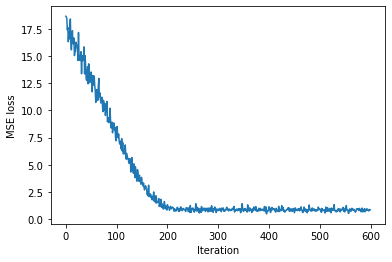

In [15]:
# Plot the learning curve

plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("MSE loss")
plt.show()

In [16]:
# Evaluate the model on the test dataset

model.compile(loss='mse')
model.evaluate(test_data)

2/2 [==============================] - 0s 3ms/step - loss: 1.0256


0.99326092004776

#### Questions
1. How would the backpropagation algorithm be modified for a different loss function, e.g. binary cross entropy loss, or a softmax function?
2. What difference would it make if we used a ReLU activation function or a sigmoid activation instead? 
3. Under what circumstances can the gradients be diminished or exploded, especially in the earlier layers of a deep network model?

## 2. Convolutional Neural Networks

In this section we will practice implementing a 1-dimensional convolutional operation in numpy. 

We will then train a CNN model with TensorFlow.

For this section you will be working with the [Human Activity Recognition (HAR) Using Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) dataset. This consists of the readings from an accelerometer (which measures acceleration) carried by a human doing different activities. The six activities are walking horizontally, walking upstairs, walking downstairs, sitting, standing and laying down. The accelerometer is inside a smartphone, and, every 0.02 seconds, it takes six readings: linear and gyroscopic acceleration in the x, y and z directions. 

The goal is to use the accelerometer data to predict the activity.

In [17]:
# Load the data

x_train = np.load('./data/HAR/x_train.npy')
y_train = np.load('./data/HAR/y_train.npy')

x_val = np.load('./data/HAR/x_val.npy')
y_val = np.load('./data/HAR/y_val.npy')

The input data consists of 6 features over 128 time steps, and the output data is a single integer from 0 to 5, which denotes the class.

There are 7,352 examples in the training set and 2,947 examples in the test set.

In [18]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(7352, 128, 6)
(7352, 1)
(2947, 128, 6)
(2947, 1)


In [19]:
classes = [
    'Walking',
    'Walking upstairs',
    'Walking downstairs',
    'Sitting',
    'Standing',
    'Laying'
]

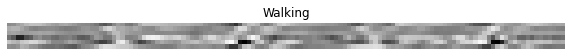

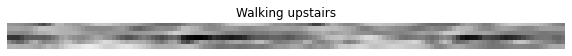

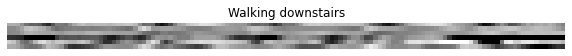

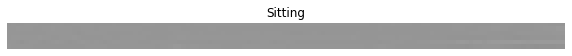

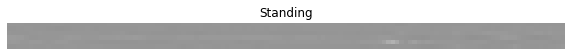

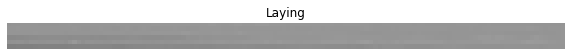

In [20]:
# Plot a randomly selected example from each class

for l, label in enumerate(range(6)):
    inx = np.where(y_train[:, 0] == label)[0]
    i = np.random.choice(inx)
    x_example = x_train[i]
    fig, ax = plt.subplots(figsize=(10, 1))
    ax.imshow(x_example.T, cmap='Greys', vmin=-1, vmax=1)
    ax.axis('off')
    ax.set_title(classes[l])

We will train a 1-D CNN classifier model on this dataset.

Now you should implement a 1-D convolutional layer in numpy. The following function should implement the convolutional transformation of this layer, given kernel and bias parameters and the input to the layer. The layer should use "VALID" padding and a stride of one. It should return the layer pre-activations (no activation function).

In [21]:
## EDIT THIS FUNCTION
def conv1d(x, K, b):
    
    # x: K x w_in x c_in array of inputs
    # K: k_w x c_in x c_out array for kernel parameters
    # b: Length c_out 1-D array for bias parameters
    # returns: K x w_out x c_out output array 
    
    
    batch_size = x.shape[0]
    w_in = x.shape[1]
    k_w = K.shape[0]
    c_out = K.shape[2]
    w_out = w_in - k_w + 1
    outputs = np.zeros((batch_size, w_out, c_out))
    
    for i in range(w_out):
        outputs[:, i, :] = (x[:, i: i + k_w, :, np.newaxis] * K).sum(axis=(1, 2)) + b ## <-- pre-activations
    return outputs

In [22]:
# Test your layer

conv_layer = tf.keras.layers.Conv1D(8, 16, activation=None)
inputs = tf.random.normal((16, 128, 6))
y_tf = conv_layer(inputs)

y = conv1d(inputs.numpy(), conv_layer.kernel.numpy(), conv_layer.bias.numpy())
np.allclose(y, y_tf.numpy(), atol=1e-4)  ## <-- should be True

True

You should now build the CNN model in TensorFlow to train on the HAR dataset. This model should consist of:

* A `Conv1D` layer with 8 filters, kernel width of 16 and a ReLU activation
  * The input shape of this first layer should be set to `(128, 6)`
  * This layer should use l2 kernel weight regularisation with a coefficient of 1e-3
* A `MaxPooling1D` layer with a pooling window size of 16
* A `Flatten` layer
* A `Dense` layer with 6 neurons and a softmax activation
  * This layer should use l2 kernel weight regularisation with a coefficient of 1e-3

The function below should build and compile this model, using an Adam optimizer and a categorical accuracy metric.

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.regularizers import l2

## EDIT THIS FUNCTION
def get_model():
    model = Sequential([
        Conv1D(8, 16, activation='relu', kernel_regularizer=l2(1e-3), input_shape=(128, 6)),
        MaxPooling1D(16),
        Flatten(),
        Dense(6, kernel_regularizer=l2(1e-3), activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [24]:
# Run your function to get the model and print the summary

model = get_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 113, 8)            776       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 8)              0         
_________________________________________________________________
flatten (Flatten)            (None, 56)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 342       
Total params: 1,118
Trainable params: 1,118
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Load the data into Dataset objects

train_data = tf.data.Dataset.from_tensor_slices((x_train.astype(np.float32), y_train.astype(np.float32)))
train_data = train_data.shuffle(1024)
train_data = train_data.batch(128)

val_data = tf.data.Dataset.from_tensor_slices((x_val.astype(np.float32), y_val.astype(np.float32)))
val_data = val_data.batch(128)

train_data.element_spec

(TensorSpec(shape=(None, 128, 6), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))

Now we are ready to train the model. The following function should run the training for a maximum of 200 epochs, validating the model with early stopping that monitors the validation accuracy, and using a patience of 15 epochs. The function should return the training history.

In [26]:
# Train the model, using early stopping

from tensorflow.keras.callbacks import EarlyStopping

def train_model(model):
    early_stopping = EarlyStopping(patience=15, monitor='val_accuracy')
    history = model.fit(train_data, epochs=200, verbose=0, validation_data=val_data,
                        callbacks=[early_stopping])
    return history

history = train_model(model)

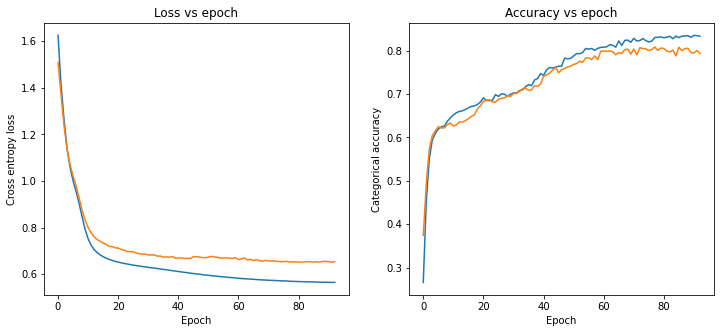

In [27]:
# Plot the learning curves

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss vs epoch")

fig.add_subplot(122)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Categorical accuracy")
plt.title("Accuracy vs epoch")

plt.show()

Now let's take a look at some model predictions!

In [28]:
# Get the model predictions

preds = model.predict(x_val)

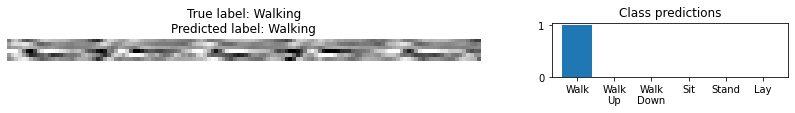

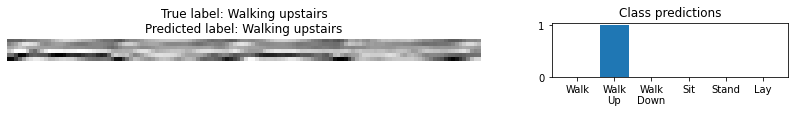

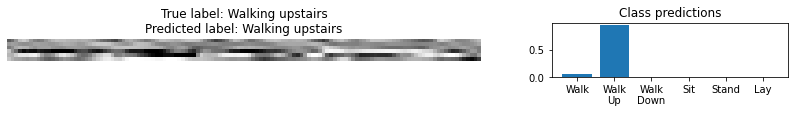

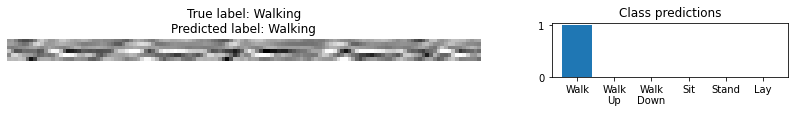

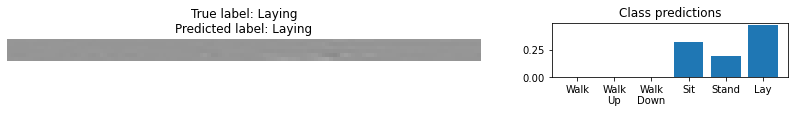

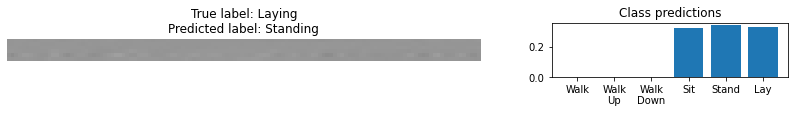

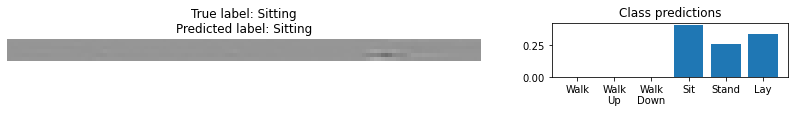

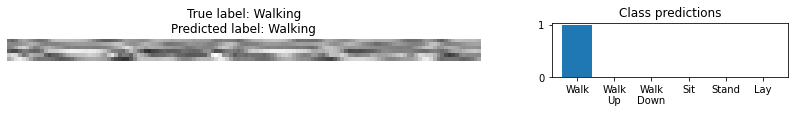

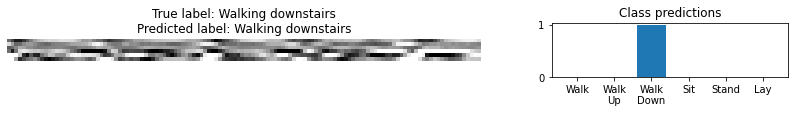

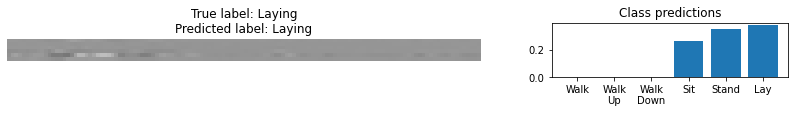

In [29]:
# Plot some example predictions

num_preds = preds.shape[0]
num_examples = 10
inx = np.random.choice(num_preds, num_examples, replace=False)
gs = {"width_ratios": [2, 1]}

for i in inx:
    x_example = x_val[i]
    true_label = y_val[i][0]
    prediction = preds[i]
    pred_class = np.argmax(prediction)
    fig, ax = plt.subplots(figsize=(14, 1), ncols=2, gridspec_kw=gs)
    ax[0].imshow(x_example.T, cmap='Greys', vmin=-1, vmax=1)
    ax[0].axis('off')
    ax[0].set_title("True label: {}\nPredicted label: {}".format(classes[true_label], classes[pred_class]))
    ax[1].bar(['Walk', 'Walk\nUp', 'Walk\nDown', 'Sit', 'Stand', 'Lay'], prediction)
    ax[1].set_title("Class predictions")

#### Questions
1. Are there particular classes where the model tends to be more uncertain in its predictions?
2. What affect does the weight regularisation have on the training and the final model? Try experimenting with no weight regularisation, and different values of the regularisation coefficient.
3. How did the patience hyperparameter impact the training run above? What would have happened if we set patience to zero?